# Plot feasible region
[![plot_feasible_region.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/plot_feasible_region.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/plot_feasible_region.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/plot_feasible_region.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/plot_feasible_region.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/plot_feasible_region.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/gomfy/ampl-lecture/plot_feasible_region.ipynb)](https://colab.ampl.com)

Description: Plot the feasible region and optimal solution for a simple two variable model using AMPL's Python API.

Tags: lecture, LP, simple

Notebook author: Gyorgy Matyasfalvi <<gyorgy@ampl.com>>, Sarah Wells <<sarah@ampl.com>>

Model author: Gyorgy Matyasfalvi, Sarah Wells

References:

In [96]:
# Install dependencies
%pip install -q amplpy

In [97]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["highs"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

## Problem formulation
Imagine you own a small lemonade stand and want to make the most profit possible. You offer two drinks: lemonade $(x)$, which requires two cups of water, one lemon and two cups of sugar per glass, and iced tea $(y)$, which requires one tea bag, one cup of sugar, and two cups of water per glass. Thankfully, you have unlimited access to water for free.

However, you have limited "dry" ingredients to work with each day, including 10 lemons, 8 tea bags, and 20 cups of sugar. Fortunately, you receive a daily inheritance of ingredients from a relative, so you don't have to worry about purchasing them.

Your goal is to determine how many glasses of each drink to make while staying within your daily ingredient limits to maximize your profit. You can sell each glass of lemonade for \\$1.50 and each glass of iced tea for \\$1.00. Since you're the only lemonade stand in town, you won't be spending any money on iced tea or lemonade anywhere else and will sell all that you make.

To formulate this as a linear programming problem, we can use the following model:

$
\begin{equation}
\begin{array}{lcrcrl}
&\textrm{Objective:}  & \max & 1.5x & + & y & \\
&\textrm{Subject to:} &      &      &   &   & \\
&                     &      &    x &   &   & \leq 10 \\
&                     &      &      &   & y & \leq 8 \\
&                     &      &   2x & + & y & \leq 20 \\
&                     &      &    x &   &   & \geq 0 \\
&                     &      &      &   & y & \geq 0
\end{array}
\end{equation}
$

### Problem formulation in AMPL
A parametric formulation of the above linear program in AMPL looks as follows:

```ampl
# Define indexing sets
set PROD;
set INGR;

# Define the decision variables
var make{PROD} >= 0;

# Define model parameters        
param profit_per_product{PROD};
param limit{INGR};
param usage{INGR, PROD};

# Define the objective function
maximize total_profit:
    sum {i in PROD} profit_per_product[i] * make[i];
    
# Define the constraints
subject to ingredient_constraints {i in INGR}:
    sum {j in PROD} usage[i,j] * make[j] <= limit[i];
```

The data file corresponding to this problem is:

```ampl
# Products (columns of constraint matrix, cardinality equals number of variables)
set PROD := 'lemonade' 'iced_tea';

# Ingredients (rows of constraint matrix, cardinality equals number of constraints)
set INGR :=
'lemon'
'tea_bag'
'sugar';

# Objective function parameters
param profit_per_product := 'lemonade' 1.5 'iced_tea' 1.0;

# Constraint right hand side values
param limit :=
'lemon'     10
'tea_bag'    8
'sugar'     20;

# Constraint matrix values
param usage: 'lemonade' 'iced_tea' :=
    'lemon'     1.0         0.0
    'tea_bag'   0.0         1.0
    'sugar'     2.0         1.0;
```


## Solving the problem

### Create an AMPL instance and specify model and data
To solve the optimization problem, we need to create an instance of AMPL and specify the model and data. The AMPL instance allows us to send the model and data we defined in the previous section to AMPL for processing.

In [98]:
# Create an AMPL instance
ampl = AMPL()

# Send model and data to AMPL
ampl.eval(
    r"""
    set PROD;
    set INGR;
    
    var make{PROD} >= 0;
    
    param profit_per_product{PROD};
    param limit{INGR};
    param usage{INGR, PROD};
    
    maximize total_profit:
        sum {i in PROD} profit_per_product[i] * make[i];
    
    subject to ingredient_constraints {i in INGR}:
        sum {j in PROD} usage[i,j] * make[j] <= limit[i];
    
    data;
    set PROD := 'lemonade' 'iced_tea';

    set INGR :=
    'lemon'
    'tea_bag'
    'sugar';

    param profit_per_product := 'lemonade' 1.5 'iced_tea' 1.0;

    param limit :=
    'lemon'     10
    'tea_bag'    8
    'sugar'     20;

    param usage: 'lemonade' 'iced_tea' :=
        'lemon'     1.0         0.0
        'tea_bag'   0.0         1.0
        'sugar'     2.0         1.0;
"""
)

### Solve the problem
Using the amplpy API, we can directly set solver options and invoke the solve command to find the optimal solution to the optimization problem. Once we have solved the problem, we can retrieve the optimal values of make and print them to the console.

In [99]:
# Solve problem with solver highs
ampl.option["solver"] = "highs"
ampl.solve()

# Retrieve and display variable bounds and the solution
make_ub = ampl.var["make"].get_values(["ub"]).to_dict()
# print(make_ub)
make_lb = ampl.var["make"].get_values(["lb"]).to_dict()
# print(make_lb)
make = ampl.var["make"].get_values().to_dict()
# print(make)
lemonade_opt = make["lemonade"]
iced_tea_opt = make["iced_tea"]

HiGHS 1.5.1: HiGHS 1.5.1: optimal solution; objective 17
0 simplex iterations
0 barrier iterations


## Plotting of feasible region
To plot the feasible region, we need to retrieve the "constraint matrix" defined by the `usage` parameter and the right-hand side values of the constraints defined by the `limit` parameter. Once we have obtained these values, we can use them to generate the necessary data for plotting the feasible region.

In [100]:
# Get model entities necessary for plotting
INGR_LIST = ampl.set["INGR"].to_list()
# print("INGR_LIST:", INGR_LIST)
limit_dict = ampl.param["limit"].to_dict()
# print("limit_dict:", limit_dict)
usage_dict = ampl.param["usage"].to_dict()
# print("usage_dict:", usage_dict)

### Solving for `iced_tea`
To plot the feasible regions, we need to solve for `iced_tea` in each of our constraints, which corresponds to the `y` axis. Each constraint is associated with one of our "dry" ingredients. We will use a dictionary of lambda expressions, each of which expresses `iced_tea`, to help us with this.

In [101]:
# Add constraint or every ingredient.
# If the coefficient value of 'iced_tea' is zero we simply return the right hand side value.
constraint_dict = {}
for i in INGR_LIST:
    constraint_dict[i] = lambda x, i=i: (
        limit_dict[i]
        if usage_dict[i, "iced_tea"] == 0.0
        else (limit_dict[i] - usage_dict[i, "lemonade"] * x) / usage_dict[i, "iced_tea"]
    )

### Draw graph
We now have all the necessary information to plot our graphs. The `y` axis corresponds to `iced_tea` and, the `x` axis to `lemonade`. The lemons and tea bags define a natural upper bound for the number of lemonades and iced teas we can make. This will help us to bound our graph. We will plot each function in `constraint_dict`, and the intersection of regions between the axes and the functions will give us the feasible region. We finish by plotting the optimal solution as well.

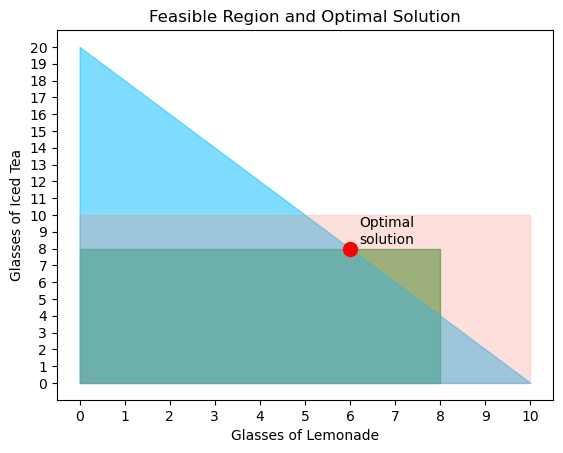

In [102]:
import numpy as np
import matplotlib.pyplot as plt

## Generate a grid of points based on variable bounds
x = np.linspace(make_lb["lemonade"], make_ub["lemonade"], 10 * int(make_ub["lemonade"]))
y = np.linspace(make_lb["iced_tea"], make_ub["iced_tea"], 10 * int(make_ub["iced_tea"]))

# Plot the feasible region
fig, ax = plt.subplots()
# Fill space between curves and x axis
ax.fill_between(y, constraint_dict["tea_bag"](y), color="green", alpha=0.5)
ax.fill_between(x, constraint_dict["sugar"](x), color="deepskyblue", alpha=0.5)
# Fill space between curves and y axis
ax.fill_betweenx(x, constraint_dict["lemon"](x), color="salmon", alpha=0.25)


# Plot the optimal solution
ax.scatter(lemonade_opt, iced_tea_opt, s=100, color="red")
ax.annotate("Optimal\nsolution", (lemonade_opt + 0.2, iced_tea_opt + 0.3))

# Generate axis ticks
# Use lower and upper bounds to determine how far on the x axis we will have to go.
xtick_range = np.arange(make_lb["lemonade"], make_ub["lemonade"] + 1, 1)
# Use generator expression to retrieve each constraint inside max() this will tell us
# how far up the y axis we will need to go.
ytick_range = np.arange(
    0, max(constraint(0) + 1 for constraint in constraint_dict.values()), 1
)
plt.xticks(xtick_range)
plt.yticks(ytick_range)


# Add labels and title
ax.set_xlabel("Glasses of Lemonade")
ax.set_ylabel("Glasses of Iced Tea")
ax.set_title("Feasible Region and Optimal Solution")

plt.show()